# Численные методы: "определение стоимости автомобилей"

## Постановка задачи:

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:
* качество предсказания;
* скорость предсказания;
* время обучения.

## Описание данных:

|Название признака|Описание|Целевой признак|
|---|---|---|
|DateCrawled|дата скачивания анкеты из базы|False|
|VehicleType|тип автомобильного кузова|False|
|RegistrationYear|год регистрации автомобиля|False|
|Gearbox|тип коробки передач|False|
|Power|мощность (л. с.)|False|
|Model|модель автомобиля|False|
|Kilometer|пробег (км)|False|
|RegistrationMonth|месяц регистрации автомобиля|False|
|FuelType|тип топлива|False|
|Brand|марка автомобиля|False|
|NotRepaired|была машина в ремонте или нет|False|
|DateCreated|дата создания анкеты|False|
|NumberOfPictures|количество фотографий автомобиля|False|
|PostalCode|почтовый индекс владельца анкеты (пользователя)|False|
|LastSeen|дата последней активности пользователя|False|
|Price|цена (евро)|True|

### Библиотеки

In [1]:
# базовые библиотеки
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore") 
from tqdm import tqdm_notebook
from scipy.sparse import hstack, vstack, csc_matrix
import os, re, sys, gc, pickle, time
from collections import defaultdict
import joblib

# валидация, оптимизация гиперпараметров
from sklearn.model_selection import GridSearchCV, cross_val_score,\
                                    KFold, train_test_split, cross_validate, ParameterGrid

# пайплайн
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin,  clone
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, OneHotEncoder

# дамми-регрессор
from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import time
from sklearn.feature_selection import SelectFromModel
import shutil

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

### Вспомогательные функции

In [71]:
def dump_pickle(filename,array):
    with open(filename, 'wb') as f:
        pickle.dump(array, f)
def load_pickle(filename):
    with open(filename, 'rb') as f:
        file= pickle.load(f)
    return file

def convert_types(df):
    '''конвертирует типы (по возможности)'''
    df_c = df.copy()
    for col in df.columns:
        ser = df[col]
        try:
            ser2 = ser.astype('datetime64')
            df_c[col] = ser2
        except:
            try:
                ser2 =ser.astype(int)
                if (ser != ser2).any():
                    try:
                        df_c[col] =ser.astype(float)
                    except:
                        pass
                    
            except:
                pass
        
    try:
        return pd.concat([df_c.select_dtypes('datetime64'), df_c.select_dtypes(exclude = ['datetime64'])], 1)
    except:
        return df_c
    
def train_hold_test_split(features, target, tr_size, ho_size, shuffle, random_state, stratify, use_test):
    if use_test:
        # делим данные на тренировочную, отложенную, тестовую части
        features_trho, features_te, target_trho, target_te = train_test_split(\
                                                                       features, target,\
                                                                       train_size = tr_size,\
                                                                       shuffle = shuffle, random_state = random_state,\
                                                                       stratify = stratify)
        features_tr, features_ho, target_tr, target_ho = train_test_split(\
                                                                       features_trho, target_trho,\
                                                                       train_size = 1-ho_size,\
                                                                       shuffle = shuffle, random_state = random_state,\
                                                                       stratify = stratify)
        print('train size = {}, hold size ={}, test size = {}'\
              .format(features_tr.shape[0], features_ho.shape[0], features_te.shape[0]))
        return (features_tr, features_ho, features_te, target_tr, target_ho, target_te)
    else:
        # делим данные на тренировочную, отложенную, тестовую части
        features_tr, features_ho, target_tr, target_ho = train_test_split(\
                                                             features, target,\
                                                             train_size = tr_size,\
                                                             shuffle = shuffle, random_state = random_state,\
                                                             stratify = stratify)
        print('train size = {}, hold size ={}'\
              .format(features_tr.shape[0], features_ho.shape[0]))
        return (features_tr, features_ho, target_tr, target_ho)
    
class SklearnHelperColumnSelector(BaseEstimator, TransformerMixin):
    '''выбирает колонки, отпавляемые в пайплайн'''
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.columns]

class SklearnHelperLabelEncoder(TransformerMixin, BaseEstimator):
    ''' Факторизация категорий '''
    def __init__(self):
        pass
    def fit(self, X, y=None):
        X_c = X.astype(str)
        self.d1 = {}
        for col in X_c.columns:
            uniques = X_c[col].dropna().unique() 
            self.d1[col] =  dict(zip(uniques, range(len(uniques))))              
        return self
    def transform(self, X): 
        X_c = X.astype(str)
        for key, value in self.d1.items():
            X_c[key] = X_c[key].map(value)
        return X_c

class SklearnHelperTargetEncoder(BaseEstimator, TransformerMixin):
    ''' Кодирование категорий с помощью целевой переменной '''
    def __init__(self, n_iter, n_folds, min_samples_leaf, seed):
        self.n_iter = n_iter
        self.n_folds = n_folds
        self.min_samples_leaf = min_samples_leaf
        self.seed = seed
    def fit(self, X, y=None):
        self.y_mean = y.mean()
        _df_tr = pd.concat([X, y], 1)
        target_col = _df_tr.columns[-1]
        to_encode = _df_tr.columns[:-1]
        
        L_tr = []        
        self.L_d_encs = []
        for i in tqdm_notebook(range(self.n_iter)): 
            enc_tr = pd.DataFrame(index = _df_tr.index, columns = to_encode).fillna(0.0)
            for col in to_encode:
                for tr_idx, val_idx in KFold(self.n_folds, shuffle = True,random_state = self.seed+i)\
                                       .split(_df_tr):                    
                    grp = _df_tr.iloc[tr_idx].groupby(col)[target_col].agg({'mean', 'count'}) 
                    d_enc = grp[grp['count']>=self.min_samples_leaf]['mean'].to_dict()
                    self.L_d_encs.append((col, d_enc))
                    to_enc_tr =_df_tr.iloc[val_idx]                    
                    enc_tr.loc[to_enc_tr.index, col] = to_enc_tr[col].map(d_enc)                  
            L_tr.append(enc_tr)    
            
        self.enc_tr =  pd.concat(L_tr, 1)
        self._df_tr = _df_tr
        return self    
    def transform(self, X):
        if np.all(X.values == self._df_tr.values):
            return self.enc_tr.fillna(self.y_mean) 
        else:
            df_enc = pd.DataFrame(index = X.index, columns=X.columns).fillna(0.0)
            for feat, d in tqdm_notebook(self.L_d_encs):
                df_enc.loc[:, feat] += X[feat].map(d) / self.n_iter
            return df_enc.fillna(self.y_mean)

class SklearnHelperFeatureSelector(BaseEstimator, TransformerMixin):
    ''' Отбор признаков '''
    def __init__(self, model, cv, scoring, show_progress):
        self.model = model
        self.cv = cv
        self.scoring = scoring
        self.show_progress = show_progress
    def fit(self, X, y=None):
        try:
            _X = X.todense()
        except:
            _X =X.copy()            
        cv_scores = []
        for i in tqdm_notebook(range(_X.shape[1])):
            _X_curr = _X[:, i].reshape(-1,1)
            mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()
            
            cv_scores.append(mean_cv_score)
        order = np.argsort(cv_scores)[::-1]
        to_drop_before, best_features, best_cv_score = [], [], -np.inf
        for i in tqdm_notebook(order):
            curr_features = best_features+[i]
            _X_curr = _X[:, curr_features]
            mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()
            if mean_cv_score>best_cv_score:
                best_cv_score = mean_cv_score
                best_features = curr_features
                if self.show_progress:
                    print('new best score = {:.5f}'.format(best_cv_score))
            else:
                to_drop_before.append(i)
        while True:
            to_drop_after = []
            for i in tqdm_notebook(to_drop_before):
                curr_features = best_features+[i]
                _X_curr = _X[:, curr_features]
                mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()
                if mean_cv_score>best_cv_score:
                    best_cv_score = mean_cv_score
                    best_features = curr_features
                    if self.show_progress:
                        print('new best score = {:.5f}'.format(best_cv_score))
                else:
                    to_drop_after.append(i)
            if to_drop_before == to_drop_after:
                break
            else:
                to_drop_before = to_drop_after  
        self.best_features = best_features
        self.best_cv_score = best_cv_score
    def transform(self, X):
        if isinstance(X, csc_matrix):
            _X = X.copy()
        else:            
            _X = csc_matrix(X) 
        return _X[:, self.best_features]
    
    

class SklearnHelperMetaFeaturesRegressor(TransformerMixin, BaseEstimator):    
    def __init__(self, base_model, nfolds, seed, path_to_folder):
        self.base_model = base_model   
        self.nfolds = nfolds
        self.kf = KFold(nfolds, random_state = seed, shuffle = True)
        self.path_to_folder=path_to_folder
    def fit(self, X, y=None):        
        if not os.path.exists(self.path_to_folder):
            os.makedirs(self.path_to_folder)
        else:
            shutil.rmtree(self.path_to_folder)
            os.makedirs(self.path_to_folder)
            
        self.X = X
        self.Z_tr = np.zeros((len(y), 1))
        for i, (tr_idx, val_idx) in tqdm_notebook(enumerate(self.kf.split(X, y)),\
                                                  total = self.kf.n_splits):
            # обучаем модель на тренировочной части
            self.base_model.fit(X[tr_idx], y[tr_idx])
            path_to_model= os.path.join(self.path_to_folder, f'model_{i}.pkl')            
            joblib.dump(self.base_model, path_to_model)               
            # предсказываем валидационную
            self.Z_tr[val_idx, 0] = self.base_model.predict(X[val_idx]) 
        return self
    def predict(self, X):
        if isinstance(self.X, (np.ndarray, np.generic)):
            if np.array_equal(self.X, X, equal_nan=True):
                return self.Z_tr.flatten()
        elif isinstance(self.X, (csc_matrix)):
            if np.array_equal(self.X[:,0].toarray().flatten(), X[:,0].toarray().flatten(), equal_nan=True):
                return self.Z_tr.flatten()
        predictitons=np.zeros((X.shape[0], self.nfolds))
        for i, filename in enumerate(os.listdir(self.path_to_folder)):
            path_to_model= os.path.join(self.path_to_folder, filename)
            fitted_model = joblib.load(path_to_model)   
            predictitons[:, i] = fitted_model.predict(X)
        return np.mean(predictitons, 1).flatten()
            
        
class SklearnHelperRegressorValidator(BaseEstimator, TransformerMixin):
    def __init__(self, model, cv, cv_scoring, ho_scoring_func, to_tune=True):
        self.model = model
        self.cv = cv
        self.cv_scoring = cv_scoring
        self.ho_scoring_func = ho_scoring_func
        self.to_tune = to_tune
    def fit(self, X_tr, y_tr, X_ho, y_ho):
        #######################################################################################################
        def _hp_tune_v1(model, grid, X, y, cv, scoring):    
            gs = GridSearchCV(model,param_grid=grid,cv = cv, scoring = scoring, n_jobs=-1, verbose = 1)
            gs.fit(X, y)
            best_estimator_ = clone(gs.best_estimator_)
            del gs
            gc.collect()    
            return best_estimator_

        def _hp_tune_v2(model, grid1, grid2, grid3, X_tr, y_tr, X_ho, y_ho, cv, scoring): 
            fit_params={'early_stopping_rounds':10,\
                        'eval_set':[(X_ho, y_ho)],\
                        'verbose':0}
            gs = GridSearchCV(model, param_grid=grid1, cv = cv, scoring=scoring, n_jobs=-1, verbose=1)
            gs.fit(X_tr, y_tr, **fit_params)    
            bp = gs.best_params_
            model = model.set_params(**bp)
            del gs
            gc.collect()

            gs = GridSearchCV(model,param_grid = grid2, cv = cv, scoring = scoring, n_jobs=-1, verbose = 1)
            gs.fit(X_tr, y_tr, **fit_params)    
            bp.update(gs.best_params_)
            model = model.set_params(**bp)
            del gs
            gc.collect()
            bp_c = bp.copy()

            best_score = -np.inf
            for params in tqdm_notebook(list(ParameterGrid(grid3))):
                bp_c.update(params)
                model = model.set_params(**bp_c)
                mean_cv_score = cross_val_score(model, X_tr, y_tr, cv=cv, scoring =scoring, n_jobs=-1).mean()
                if mean_cv_score>best_score:
                    best_score = mean_cv_score            
                    best_estimator_ = model
                else:
                    break
            return clone(best_estimator_)        
        ##############################################################################################################
        
        if not(self.to_tune):
            self.best_model = self.model
            self.mean_cv_score = cross_val_score(self.best_model, X_tr, y_tr, cv=self.cv, scoring=self.cv_scoring).mean()
            self.best_model.fit(X_tr, y_tr)
            if self.predict_proba:
                self.ho_score = self.ho_scoring_func(y_ho, self.best_model.predict_proba(X_ho)[:, 1])
            else:
                self.ho_score = self.ho_scoring_func(y_ho, self.best_model.predict(X_ho))                                             
        else:
            if type(self.model).__name__ in ('DecisionTreeRegressor', 'ExtraTreeRegressor'):
                tree_pg = {'max_depth':np.arange(7, 41), 'min_samples_leaf':[2, 20, 200]}
                self.best_model = _hp_tune_v1(self.model, tree_pg, X_tr, y_tr, cv=self.cv, scoring=self.cv_scoring)
                
                self.mean_cv_score = cross_val_score(self.best_model, X_tr, y_tr, cv=self.cv, scoring=self.cv_scoring).mean()
                self.best_model.fit(X_tr, y_tr)
                self.ho_score = self.ho_scoring_func(y_ho, self.best_model.predict(X_ho))
            elif type(self.model).__name__ in ('RandomForestRegressor', 'RandomForestClassifier',\
                                               'ExtraTreesRegressor', 'ExtraTreesClassifier'):
                init_params = self.model.get_params()
                trees_pg = {'max_depth':np.arange(5, 21),'min_samples_leaf':[2, 20],'n_estimators':[10],\
                            'n_jobs':[-1], 'random_state':[init_params['random_state']]}
                self.best_model = _hp_tune_v1(self.model,trees_pg, X_tr, y_tr, cv=self.cv, scoring=self.cv_scoring)
                bp = init_params
                best_par = self.best_model.get_params()
                del best_par['n_estimators']
                bp.update(**best_par)
                self.best_model = self.best_model.set_params(**bp)
                
                self.mean_cv_score = cross_val_score(self.best_model, X_tr, y_tr, cv=self.cv, scoring=self.cv_scoring).mean()                
                self.best_model.fit(X_tr, y_tr)
                self.ho_score = self.ho_scoring_func(y_ho, self.best_model.predict(X_ho))
                
            elif type(self.model).__name__ in ('LGBMRegressor', 'LGBMClassifier'): 
                init_params = self.model.get_params()
                lgb_grid1 = {'n_estimators':[10], 'n_jobs':[-1], 'random_state':[init_params['random_state']],\
                             'max_depth':np.arange(4, 21).tolist(),\
                             'num_leaves':[32, 64, 128, 256, 512, 1024],\
                             'min_child_samples':[20, 50]}
                lgb_grid2 = {'subsample':np.linspace(.1, 1, 10),\
                             'colsample_bytree':np.linspace(.1, 1, 10)}
                lgb_grid3 = {'learning_rate':np.linspace(.01, .1, 10), 'n_estimators':[init_params['n_estimators']]}
    
                self.best_model = _hp_tune_v2(LGBMRegressor(n_jobs=-1),\
                                            lgb_grid1, lgb_grid2, lgb_grid3,\
                                            X_tr, y_tr, X_ho, y_ho,\
                                            cv=self.cv, scoring=self.cv_scoring)
                lr = self.best_model.get_params()['learning_rate']
                gs = GridSearchCV(self.best_model,\
                               param_grid = {'learning_rate':np.linspace(lr-.09,lr+.09, 10)},\
                               cv=self.cv, scoring=self.cv_scoring, verbose = 1)
                gs.fit(X_tr, y_tr)
                self.best_model = gs.best_estimator_                    
                self.mean_cv_score = cross_val_score(self.best_model, X_tr, y_tr, cv=self.cv, scoring=self.cv_scoring).mean()                
                self.best_model.fit(X_tr, y_tr)
                self.ho_score = self.ho_scoring_func(y_ho, self.best_model.predict(X_ho))
                
            elif type(self.model).__name__ in ('XGBRegressor', 'XGBClassifier'): 
                init_params = self.model.get_params()
                xgb_grid1 = {'n_estimators':[10], 'n_jobs':[-1], 'random_state':[init_params['random_state']],\
                             'max_depth':np.arange(4, 21).tolist(),\
                             'min_child_weight':[20, 50]}
                xgb_grid2 = {'subsample':np.linspace(.1, 1, 10),\
                             'colsample_bytree':np.linspace(.1, 1, 10)}
                xgb_grid3 = {'learning_rate':np.linspace(.01, .1, 10), 'n_estimators':[init_params['n_estimators']]}
    
                self.best_model = _hp_tune_v2(XGBRegressor(n_jobs=-1),\
                                            xgb_grid1, xgb_grid2, xgb_grid3,\
                                            X_tr, y_tr, X_ho, y_ho,\
                                            cv=self.cv, scoring=self.cv_scoring)
                lr = self.best_model.get_params()['learning_rate']
                gs = GridSearchCV(self.best_model,\
                               param_grid = {'learning_rate':np.linspace(lr-.09,lr+.09, 10)},\
                               cv=self.cv, scoring=self.cv_scoring, verbose = 1)
                gs.fit(X_tr, y_tr)
                self.best_model = gs.best_estimator_                    
                self.mean_cv_score = cross_val_score(self.best_model, X_tr, y_tr, cv=self.cv, scoring=self.cv_scoring).mean()                
                self.best_model.fit(X_tr, y_tr)
                self.ho_score = self.ho_scoring_func(y_ho, self.best_model.predict(X_ho))
            elif type(self.model).__name__ in ('LinearRegression', 'Lasso', 'Ridge'):
                pg = {'alpha':[.1, .3, .7, 1, 10, 30, 70]}
                self.best_model = _hp_tune_v1(self.model, pg, X_tr, y_tr, cv=self.cv, scoring=self.cv_scoring)
                
                self.mean_cv_score = cross_val_score(self.best_model, X_tr, y_tr, cv=self.cv, scoring=self.cv_scoring).mean()
                self.best_model.fit(X_tr, y_tr)
                self.ho_score = self.ho_scoring_func(y_ho, self.best_model.predict(X_ho))
            elif type(self.model).__name__ in ('LinearSVR'):
                pg = {'C':[.1, .3, .7, 1, 10, 30, 70]}
                self.best_model = _hp_tune_v1(self.model, pg, X_tr, y_tr, cv=self.cv, scoring=self.cv_scoring)
                
                self.mean_cv_score = cross_val_score(self.best_model, X_tr, y_tr, cv=self.cv, scoring=self.cv_scoring).mean()
                self.best_model.fit(X_tr, y_tr)
                self.ho_score = self.ho_scoring_func(y_ho, self.best_model.predict(X_ho))
        return self
    
    
    def predict(self, X):
        return self.best_model.predict(X) 
            
class SklearnHelperMulticollinearityReducer(BaseEstimator, TransformerMixin):
    def __init__(self, treshold):
        self.treshold = treshold
    def fit(self, X, y=None):
        assert isinstance(X, np.ndarray)
        D_multicoll = defaultdict(list)
        for i in tqdm_notebook(range(X.shape[1])):
            for j in range(i+1, X.shape[1]):
                x1, x2 = X[:, i], X[:, j]
                corr_x1_x2 = np.abs(np.corrcoef(x1, x2)).min()
                if corr_x1_x2>=self.treshold:
                    D_multicoll[i].append(j) 
        L_multicoll = []
        for k, v in D_multicoll.items():
            v.append(k)
            L_multicoll.append(v)
        del D_multicoll
        gc.collect()
        if len(L_multicoll)>0:
            self.to_drop = []
            for idxs in L_multicoll:
                _df = pd.DataFrame(X[:, idxs]).astype(float)                
                corr_w_target_abs = _df.corrwith(pd.Series(y)).abs()
                self.to_drop.extend(corr_w_target_abs.drop(corr_w_target_abs.idxmax()).index.tolist())
            self.to_drop = np.unique(self.to_drop)
        return self
    def transform(self, X):
        try:
            return np.delete(X, self.to_drop, axis = 1)
        except:
            return X
        
class SklearnHelperMetaFeaturesRegressor_v2(BaseEstimator, TransformerMixin):
    def __init__(self, model, seed, n_iterations, nfolds, subsamples, path_to_folder):
        self.n_iterations=n_iterations
        self.model = model
        self.seed = seed
        self.nfolds = nfolds
        self.subsamples = subsamples
        self.path_to_folder = path_to_folder
    def fit(self, X, y=None):
        if not os.path.exists(self.path_to_folder):
            os.makedirs(self.path_to_folder)
        else:
            shutil.rmtree(self.path_to_folder)
            os.makedirs(self.path_to_folder)
        nrows, ncols = X.shape
        self.X = X.copy()
        self.Z = np.zeros((nrows, self.n_iterations))
        for i in tqdm_notebook(range(self.n_iterations)):
            current_seed = i+self.seed
            np.random.seed(current_seed)    
            kf = KFold(self.nfolds, shuffle=True, random_state = current_seed)    
            feat_to_use = np.random.choice(a = np.arange(ncols),\
                                           size = np.int32(np.around(np.random.choice(self.subsamples)*ncols)),\
                                           replace = False)
            idx_permutation = np.random.permutation(np.arange(nrows))

            _X_subspace = X[idx_permutation][:, feat_to_use]
            _y = y[idx_permutation]

            for j, (tr_idx, val_idx) in enumerate(kf.split(_X_subspace, _y)):
                self.model.fit(_X_subspace[tr_idx], _y[tr_idx])                
                
                current_path = os.path.join(self.path_to_folder, f'model_{i}_{j}.pkl')
                joblib.dump([self.model, feat_to_use], current_path)
                
                self.Z[val_idx, i] = self.model.predict(_X_subspace[val_idx])
        return self
    def predict(self, X):
        if isinstance(self.X, (np.ndarray, np.generic)):
            if np.array_equal(self.X, X, equal_nan=True):
                return self.Z
        elif isinstance(self.X, (csc_matrix)):
            if np.array_equal(self.X[:,0].toarray().flatten(), X[:,0].toarray().flatten(), equal_nan=True):
                return self.Z
        L_predictitons=[]
        for i, filename in enumerate(os.listdir(self.path_to_folder)):
            path_to_model= os.path.join(self.path_to_folder, filename) 
            fitted_model, feat_to_use = joblib.load(path_to_model)
            L_predictitons.append(fitted_model.predict(X[:, feat_to_use]).flatten().reshape(-1,1))
        return np.column_stack([np.mean(np.column_stack(arr), 1)\
                                for arr in np.split(np.array(L_predictitons), self.n_iterations)])
    
class SklearnHelperDataPreparetor(BaseEstimator, TransformerMixin):
    '''
    Конвертирует типы (по возможности)
    
    '''
    def __init__(self):
        pass
    def fit(self, df): 
        self.df_c = df.copy()
        for col in df.columns:
            ser = df[col]
            try:
                ser2 = ser.astype(np.datetime64)
                self.df_c[col] = ser2
            except:
                try:
                    ser2 =ser.astype(int)
                    if (ser != ser2).any():
                        try:
                            self.df_c[col] =ser.astype(np.float32)
                        except:
                            self.df_c[col] = ser
                except:
                    self.df_c[col] = ser                    
        return self
    def transform(self):        
        try:
            return pd.concat([self.df_c.select_dtypes(np.datetime64),\
                              self.df_c.select_dtypes(exclude = [np.datetime64])], 1)
        except:
            return self.df_c  
        
class SklearnHelperDataSplitter(BaseEstimator, TransformerMixin):
    '''
    Класс для загрузки данных
    
    Параметры:
        1) tr_size        | доля тренировочной части          | float 
        2) ho_size        | доля отложенной части             | float 
        3) shuffle        | перемешивание                     | bool
        4) random_state   | генератор случайных чисел         | int
        5) stratify       | стратификация целевой переменной  | bool
        6) use_test       | исользовать тестовую часть        | bool
    
    '''
    def __init__(self, tr_size, ho_size, shuffle, random_state, stratify, use_test):
        self.tr_size = tr_size
        self.ho_size = ho_size
        self.shuffle=shuffle
        self.random_state=random_state
        self.stratify=stratify
        self.use_test = use_test
    def fit(self, X, y=None):        
        if self.use_test:
            X_trho, self.X_te, y_trho, self.y_te = train_test_split(X, y,train_size = self.tr_size,shuffle = self.shuffle,
                                                                    random_state = self.random_state,\
                                                                    stratify = y if self.stratify else None)
            
            self.X_tr, self.X_ho, self.y_tr, self.y_ho = train_test_split(X_trho, y_trho,train_size = self.tr_size,\
                                                                          shuffle = self.shuffle,
                                                                          random_state = self.random_state,\
                                                                          stratify = y_trho if self.stratify else None)
        else:
            self.X_tr, self.X_ho, self.y_tr, self.y_ho = train_test_split(X, y,train_size = self.tr_size,\
                                                                          shuffle = self.shuffle,
                                                                          random_state = self.random_state,\
                                                                          stratify = target if self.stratify else None)
        return self
    def transform(self):
        if self.use_test:
            return (self.X_tr, self.X_ho, self.X_te, self.y_tr, self.y_ho, self.y_te)
        else:
            return (self.X_tr, self.X_ho, self.y_tr, self.y_ho)     
        
def show_eda_plots(X_tr, y_tr, time_features, cat_features, num_features, min_samples_leaf): 
    if time_features is not None:
        print(str.upper('\t\t\t\t\t\t\ttime features'))
        for feat in time_features:
            ser = X_tr[feat]
            if ser.nunique()>1:        
                y_sorted = y_tr.loc[ser.index].reset_index(drop = True).cumsum()
                fig = plt.figure(figsize = (17, 4))
                plt.subplot(1, 2, 1)
                sns.kdeplot(ser, color = 'red')
                plt.xlabel(feat)
                plt.ylabel('density')
                plt.title(f'{feat} kde', fontsize = 20)
                plt.subplot(1, 2, 2)
                y_sorted.plot(color = 'red')
                plt.xlabel(feat)
                plt.ylabel('cummulative target')
                plt.title(f'cummulative target by {feat}', fontsize = 20)
                plt.show()
        
    if cat_features is not None:
        print(str.upper('\t\t\t\t\t\t\tcat_features'))
        for feat in cat_features:
            ser = X_tr[feat]
            if ser.nunique()>1:
                corr = ser.to_frame().corrwith(y_tr).round(2).values.flatten()[0]
                aggs = pd.DataFrame(np.c_[ser, y_tr]).groupby(0)[1].agg({'count', 'mean'})    
                aggs_to_plot = aggs[aggs['count']>=min_samples_leaf]['mean']
                fig = plt.figure(figsize = (17, 4))    
                plt.subplot(1, 2, 1)
                sns.kdeplot(ser, color = 'green')
                plt.xlabel(feat)
                plt.ylabel('density')
                plt.title(f'{feat} kde', fontsize = 20)
                plt.subplot(1, 2, 2)   
                aggs_to_plot.plot(color = 'green')
                plt.xlabel(feat)
                plt.ylabel('mean target value')
                plt.title(f'target by {feat}\ncorr with target = {corr}', fontsize = 20)
                plt.show()
        
    if num_features is not None:
        print(str.upper('\t\t\t\t\t\t\tnum features'))
        for feat in num_features:    
            ser = X_tr[feat]
            if ser.nunique()>1:
                fig = plt.figure(figsize = (17, 4))
                corr = ser.to_frame().corrwith(y_tr).round(2).values.flatten()[0]
                plt.scatter(ser, y_tr, alpha = .1)
                plt.title(f'target by {feat}\ncorr with target = {corr}', fontsize = 20)
                plt.xlabel(feat)
                plt.ylabel('target')
    plt.show()
    print(str.upper('\t\t\t\t\t\t\tcorrelations'))   
    corr = X_tr.select_dtypes('number').corr()    
    plt.figure(figsize = (17, 4))
    corr_flat = np.unique(corr.values.flatten())
    ax1 = plt.subplot(1, 2, 1)
    sns.kdeplot(corr_flat[corr_flat!=1], ax = ax1, color='black')
    plt.xlabel('value')
    plt.ylabel('density')
    plt.title('correlations bw features', fontsize= 20)
    ax2 = plt.subplot(1, 2, 2)
    sns.kdeplot(X_tr.select_dtypes('number').corrwith(y_tr).values.flatten(), ax = ax2, color='black')   
    plt.xlabel('value')
    plt.ylabel('density')
    plt.title('correlations bw features and target', fontsize= 20)

### Константы, метрика, валидация

In [70]:
# константы
SEED = 13
FILL_NA = -9999
# валидация
KF = KFold(3, random_state = SEED, shuffle = True)
# метрика качества
def NEG_RMSE_SCORING_FUNC(y_true, y_pred):
    return -np.sqrt(np.mean((y_true-y_pred)**2))
NEG_RMSE_SCORER = make_scorer(NEG_RMSE_SCORING_FUNC)

### Загрузка данных(добавление признаков из даты)

In [72]:
DataPreparetor = SklearnHelperDataPreparetor()
DataPreparetor.fit(pd.read_csv('datasets/autos.csv'))
df = DataPreparetor.transform()

In [73]:
# добавляем признаки
for col in ['DateCrawled', 'LastSeen']:
    df[col+'.year'] = df[col].dt.year
    df[col+'.month'] =df[col].dt.month
    df[col+'.day'] =df[col].dt.day
    df[col+'.dayofweek'] =df[col].dt.dayofweek
    df[col+'.hour'] = df[col].dt.hour    
    df[col+'.minute'] = df[col].dt.minute    
    df[col+'.weekofyear'] =df[col].dt.weekofyear
    df[col+'.quarter'] =df[col].dt.quarter    
df['DateCreated.year'] = df['DateCreated'].dt.year
df['DateCreated.month'] = df['DateCreated'].dt.month
df['DateCreated.day'] = df['DateCreated'].dt.day

							TIME FEATURES


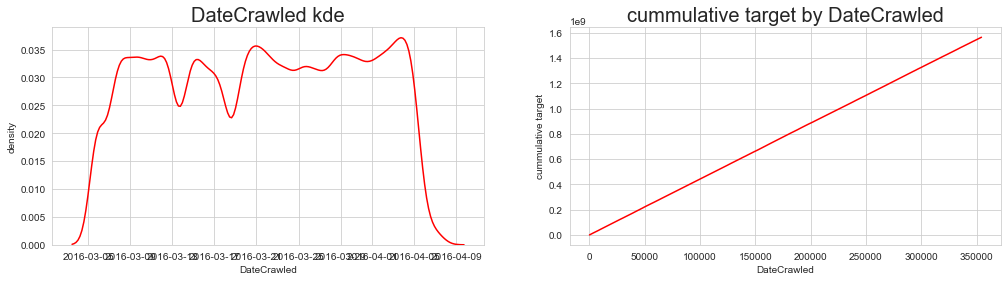

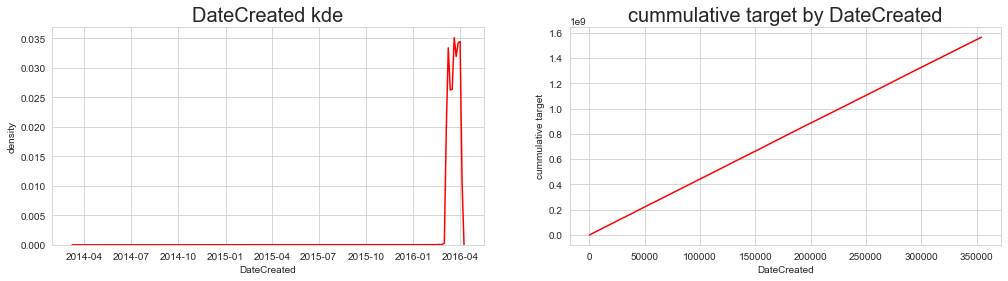

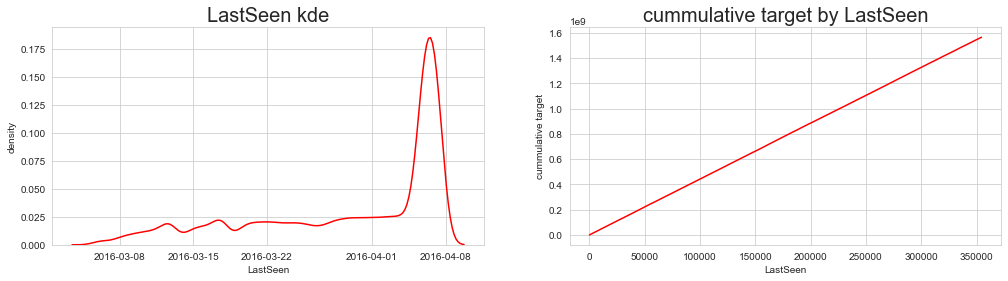

							CAT_FEATURES


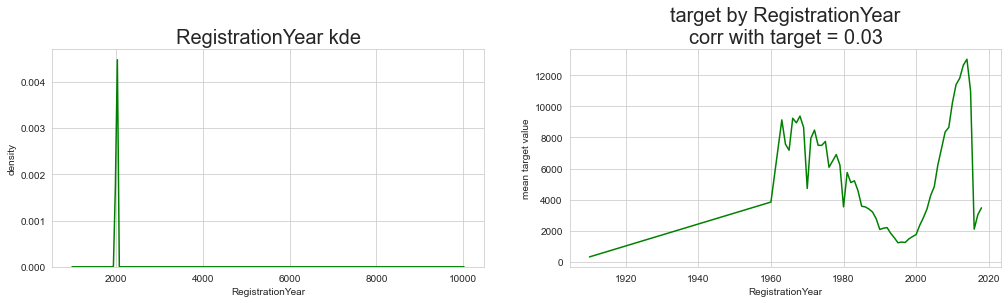

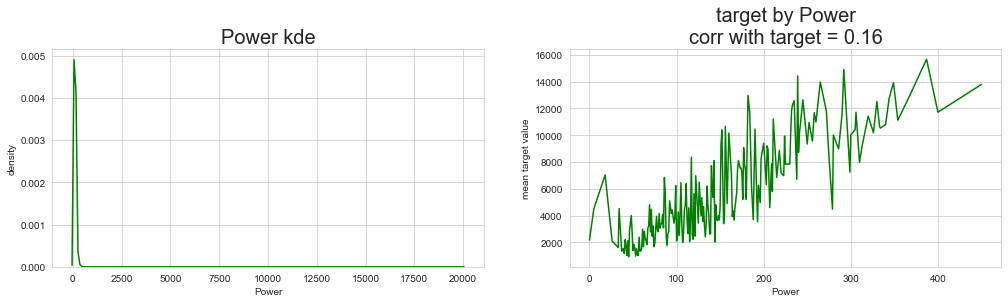

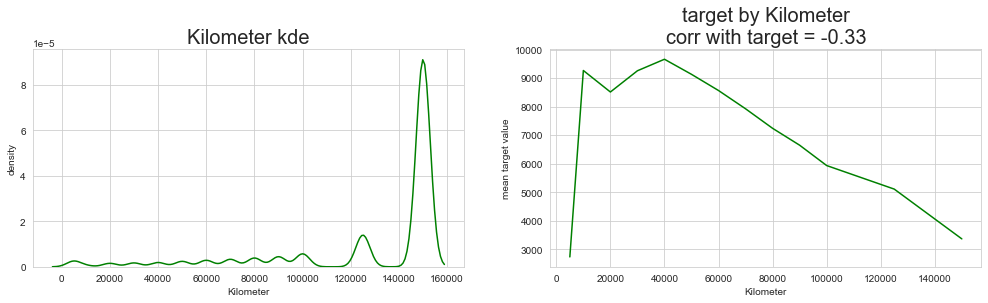

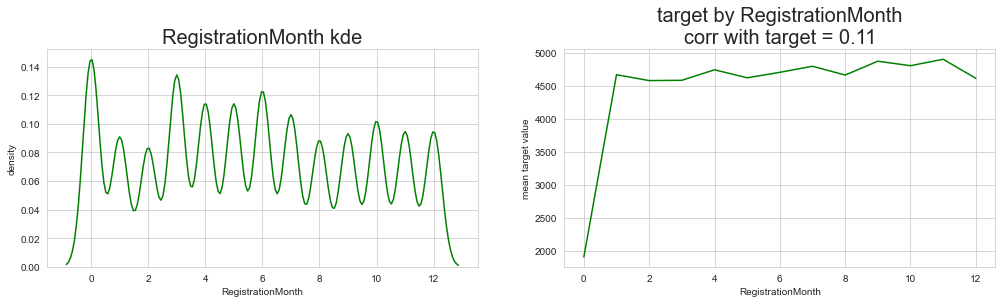

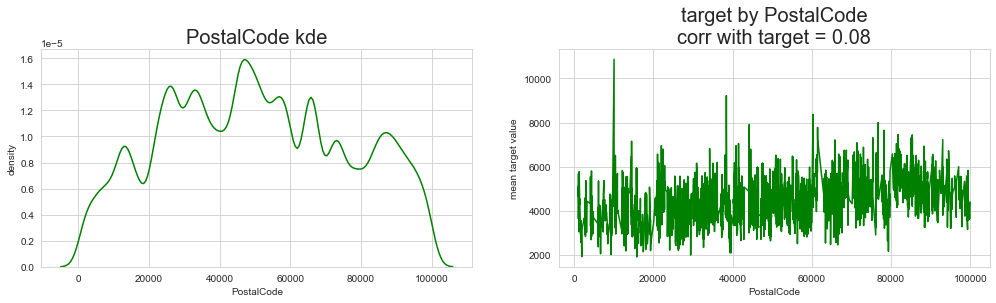

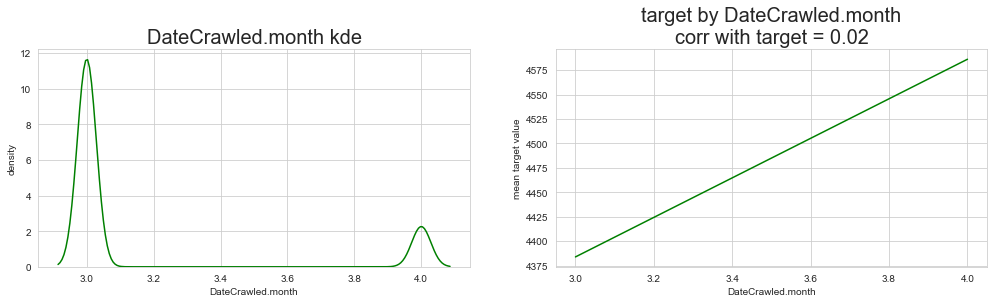

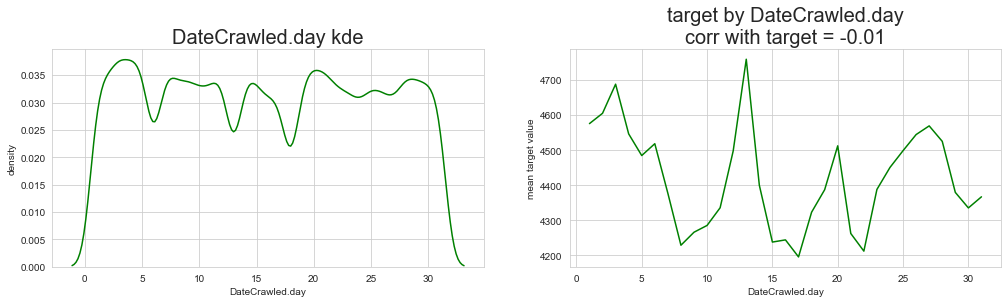

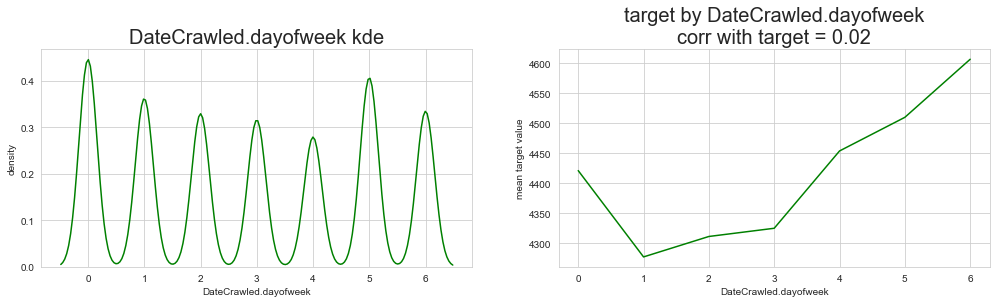

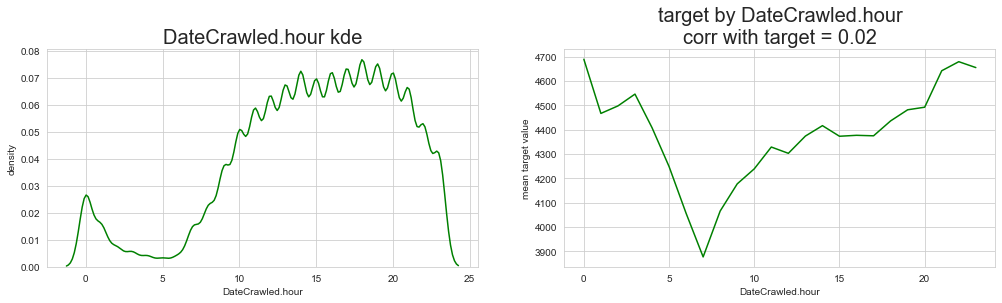

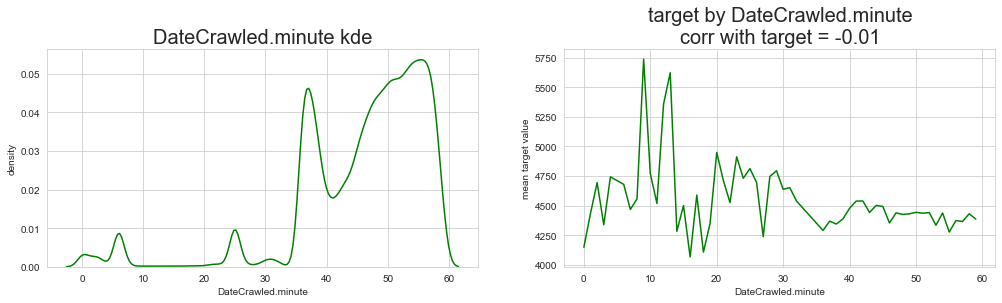

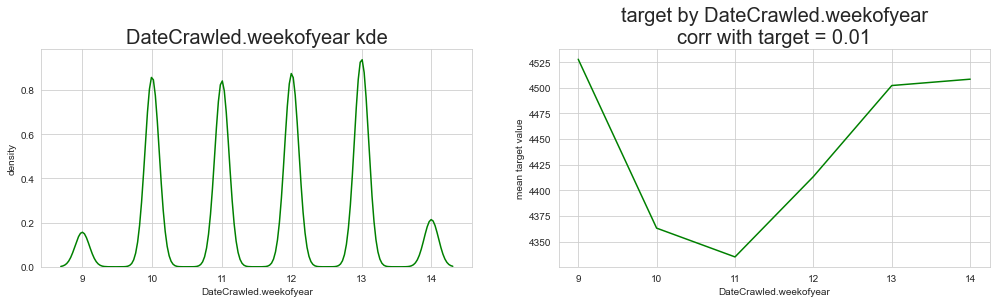

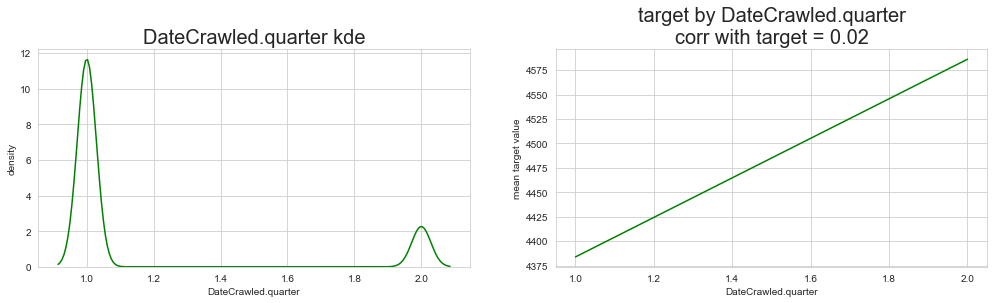

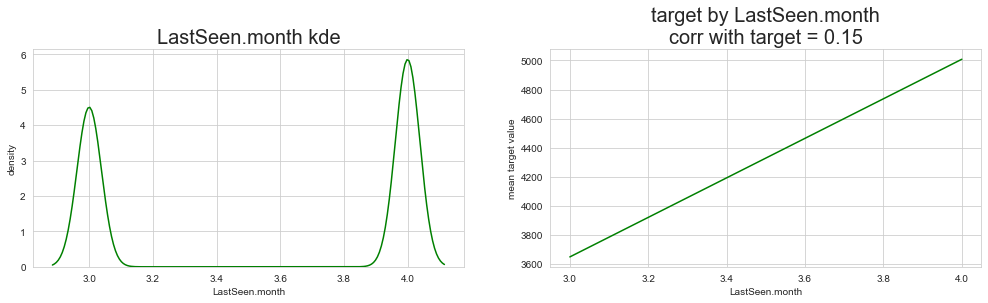

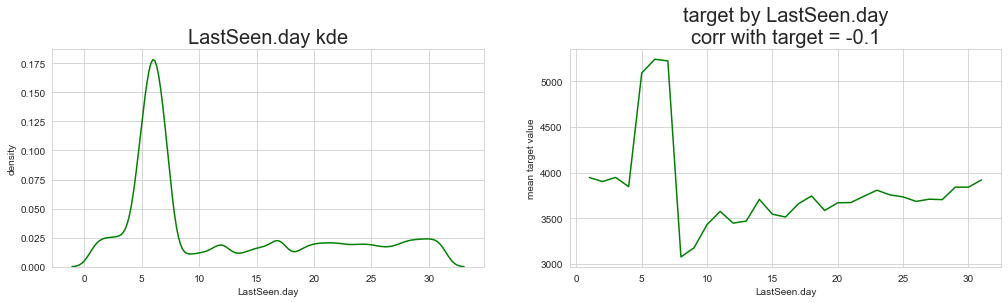

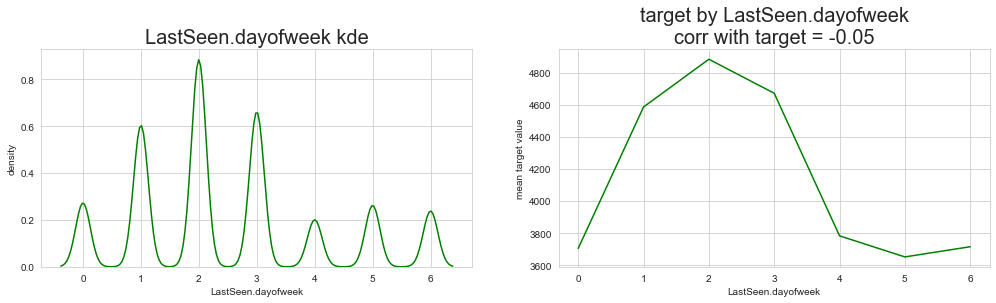

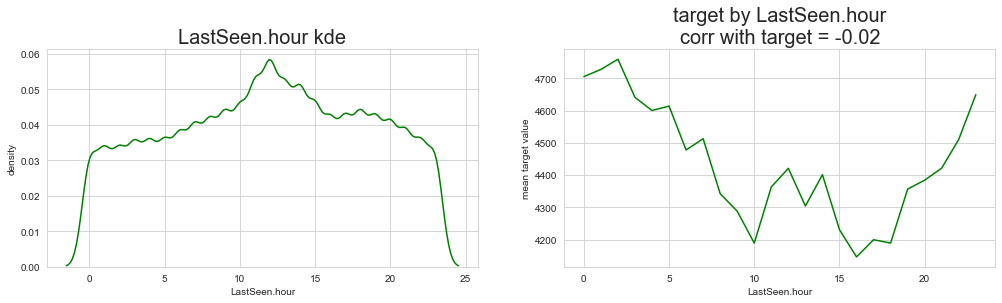

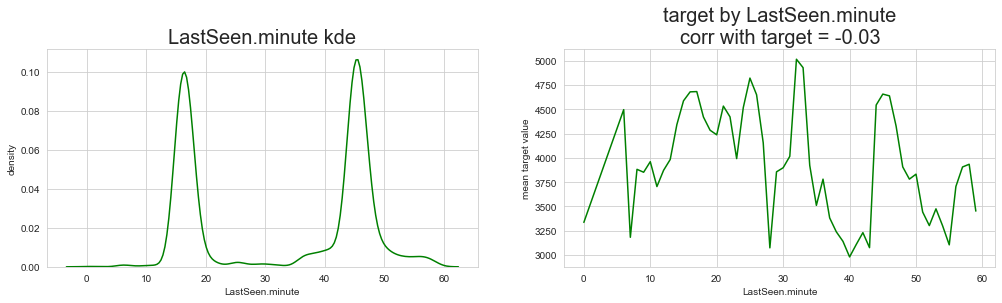

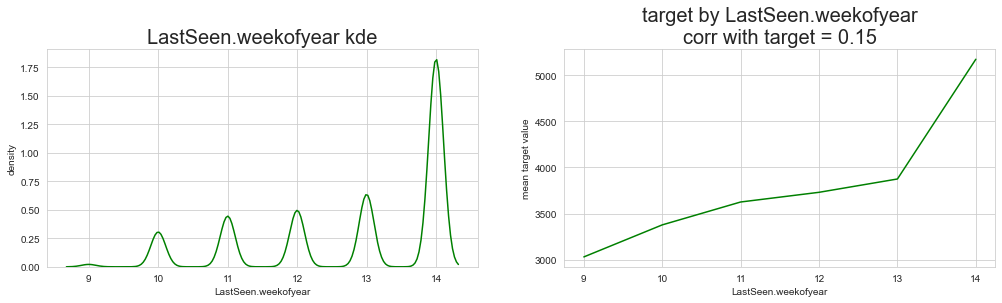

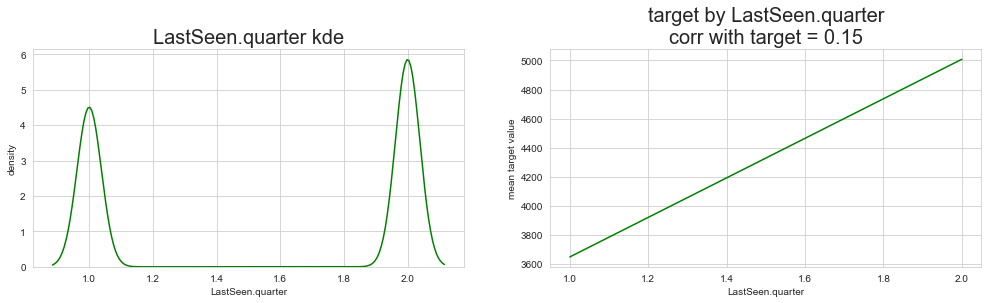

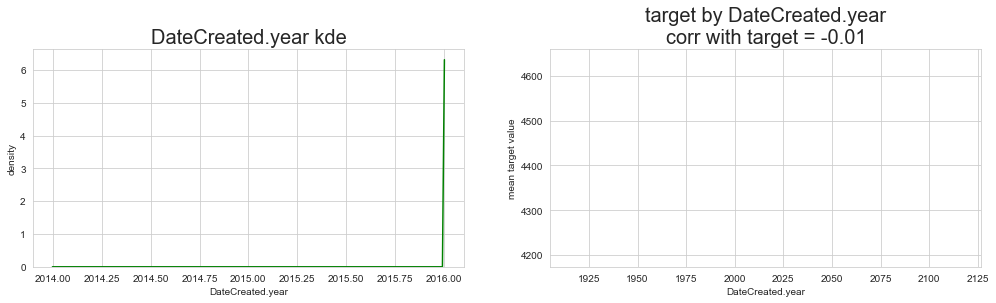

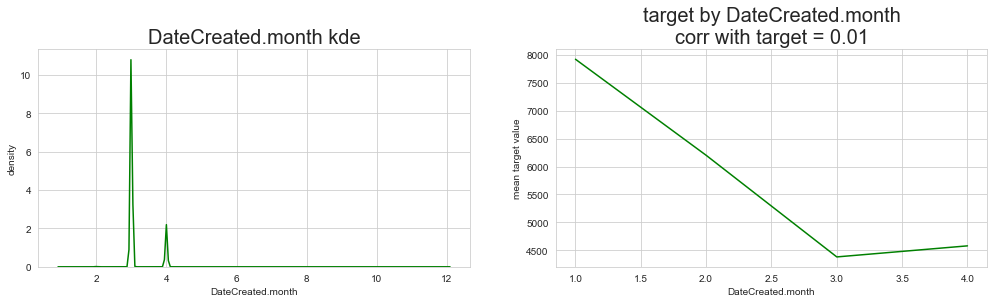

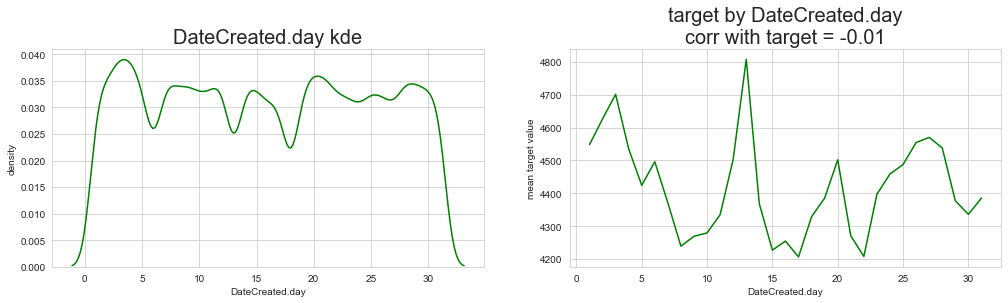

							NUM FEATURES


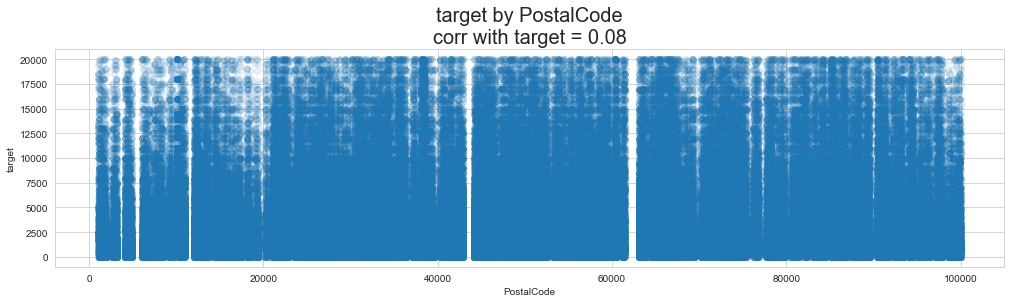

							CORRELATIONS


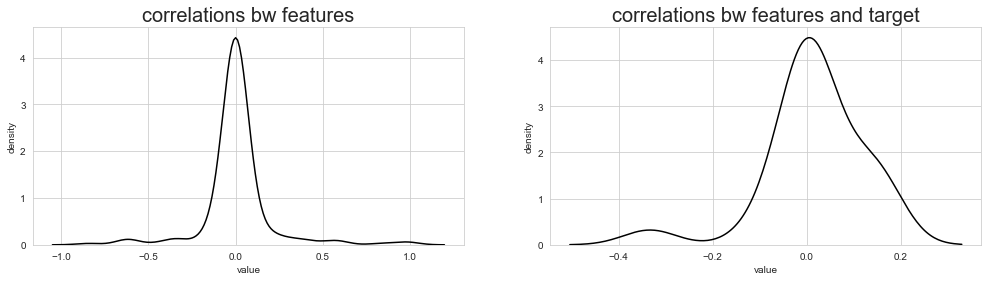

In [74]:
show_eda_plots(df.drop('Price',1), df['Price'],\
               time_features = ['DateCrawled', 'DateCreated', 'LastSeen'],\
               cat_features = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures',\
                               'PostalCode', 'DateCrawled.year', 'DateCrawled.month', 'DateCrawled.day',\
                               'DateCrawled.dayofweek', 'DateCrawled.hour', 'DateCrawled.minute',\
                               'DateCrawled.weekofyear', 'DateCrawled.quarter', 'LastSeen.year', 'LastSeen.month',\
                               'LastSeen.day', 'LastSeen.dayofweek', 'LastSeen.hour', 'LastSeen.minute',\
                               'LastSeen.weekofyear', 'LastSeen.quarter', 'DateCreated.year', 'DateCreated.month',\
                               'DateCreated.day'],\
               num_features = ['PostalCode'],\
               min_samples_leaf = 50)

### Разделение данных на 3 части: тренировочную, отложенную, тестовую

In [76]:
Splitter = SklearnHelperDataSplitter(tr_size=.9,\
                                     ho_size=.1,\
                                     shuffle=True,\
                                     random_state=SEED,\
                                     stratify=False,\
                                     use_test=True)
Splitter.fit(df.drop('Price', 1), df['Price'])
features_tr, features_ho, features_te, target_tr, target_ho, target_te = Splitter.transform()

### Пайплайны

In [77]:
# строки
str_columns = features_tr.select_dtypes(object).columns.tolist()
# числа
num_columns = features_tr.drop(str_columns, 1).columns.tolist()

In [78]:
# пайплайны для строк
ppl_str1 = Pipeline([('str_features1', SklearnHelperColumnSelector(str_columns)),\
                     ('label encoder', SklearnHelperLabelEncoder())])
ppl_str2 =Pipeline([('str_features2', SklearnHelperColumnSelector(str_columns)),\
                    ('target encoder', SklearnHelperTargetEncoder(n_iter = 5,\
                                                                  n_folds = 20,\
                                                                  min_samples_leaf = 2,\
                                                                  seed = SEED))])
ppl_num1 = Pipeline([('num_features1', SklearnHelperColumnSelector(num_columns))])
ppl_num2 =Pipeline([('num_features2', SklearnHelperColumnSelector(num_columns)),\
                    ('target encoder', SklearnHelperTargetEncoder(n_iter = 5,\
                                                                  n_folds = 20,\
                                                                  min_samples_leaf = 2,\
                                                                  seed = SEED))])

In [79]:
# полный пайплайн для деревянных моделей
ppl_tree = Pipeline([('prepare_data', FeatureUnion([('f1',ppl_str1), ('f2',ppl_str2), ('f3',ppl_num1), ('f4',ppl_num2)])),\
                     ('scale', MaxAbsScaler()),\
                     ('impute', SimpleImputer(fill_value = FILL_NA)),\
                     ('select_features',SklearnHelperFeatureSelector(model = LGBMRegressor(n_jobs=-1, random_state = SEED),\
                                                                     cv = KF,  scoring = NEG_RMSE_SCORER,
                                                                     show_progress = True))])                     
y_tr, y_ho, y_te = target_tr.values, target_ho.values, target_te.values

In [10]:
ppl_tree.fit(features_tr, target_tr)

X_tree_tr = ppl_tree.transform(features_tr).toarray()
X_tree_ho = ppl_tree.transform(features_ho).toarray()
X_tree_te = ppl_tree.transform(features_te).toarray() 

In [11]:
ols = LinearRegression(normalize = True)
oh_encoder = OneHotEncoder(handle_unknown = 'ignore')
to_ohe = []

# проходим по признакам для деревянных моделей
for i in tqdm_notebook(range(X_tree_tr.shape[1])):
    
    # текущий столбец
    x_raw = X_tree_tr[:, i].reshape(-1,1)
    # дамми-кодирование
    x_ohe = oh_encoder.fit_transform(x_raw)
    
    # валидация
    mean_cv_raw = cross_val_score(ols, x_raw, y_tr, cv = KF, scoring = NEG_RMSE_SCORER).mean()
    mean_cv_ohe = cross_val_score(ols, x_ohe, y_tr, cv = KF, scoring = NEG_RMSE_SCORER).mean()
    
    # эффект от дамми-кодирования
    ohe_effect = mean_cv_ohe / mean_cv_raw
    if ohe_effect<=.95:
        to_ohe.append(i)   
        
oh_encoder.fit(X_tree_tr[:, to_ohe])
X_lin_tr = csc_matrix(hstack([np.delete(X_tree_tr, to_ohe, axis = 1), oh_encoder.transform(X_tree_tr[:, to_ohe])]))
X_lin_ho = csc_matrix(hstack([np.delete(X_tree_ho, to_ohe, axis = 1), oh_encoder.transform(X_tree_ho[:, to_ohe])]))
X_lin_te = csc_matrix(hstack([np.delete(X_tree_te, to_ohe, axis = 1), oh_encoder.transform(X_tree_te[:, to_ohe])]))

In [12]:
# регуляризация
alphas = [.005, .006, .007]
# лучшее значение метрики
best_score = -np.inf

# подбираем регуляризацию
for alpha in tqdm_notebook(alphas):
    selector = Lasso(alpha = alpha, normalize = True)
    selector.fit(X_lin_tr, y_tr)
    mask = selector.coef_!=0
    mean_cv_score = cross_val_score(ols, X_lin_tr[:, mask], y_tr, cv = KF, scoring = NEG_RMSE_SCORER).mean()
    if mean_cv_score>best_score:
        best_score = mean_cv_score
        X_sel_lin_tr, X_sel_lin_ho, X_sel_lin_te = X_lin_tr[:, mask], X_lin_ho[:, mask], X_lin_te[:, mask] 
        
X_lin_tr, X_lin_ho, X_lin_te = X_sel_lin_tr, X_sel_lin_ho, X_sel_lin_te
del X_sel_lin_tr, X_sel_lin_ho, X_sel_lin_te
gc.collect()

In [13]:
# dump_pickle(filename='X_tree_tr.pickle',array=X_tree_tr)
# dump_pickle(filename='X_tree_ho.pickle',array=X_tree_ho)
# dump_pickle(filename='X_tree_te.pickle',array=X_tree_te)

# dump_pickle(filename='X_lin_tr.pickle',array=X_lin_tr)
# dump_pickle(filename='X_lin_ho.pickle',array=X_lin_ho)
# dump_pickle(filename='X_lin_te.pickle',array=X_lin_te)

In [80]:
X_tree_tr = load_pickle('X_tree_tr.pickle')
X_tree_ho = load_pickle('X_tree_ho.pickle')
X_tree_te = load_pickle('X_tree_te.pickle')

X_lin_tr = load_pickle('X_lin_tr.pickle')
X_lin_ho = load_pickle('X_lin_ho.pickle')
X_lin_te = load_pickle('X_lin_te.pickle')

y_tr, y_ho, y_te = target_tr.values, target_ho.values, target_te.values

### Валидация моделей

In [7]:
# бейзлайн
mean_cv_baseline = cross_val_score(DummyRegressor('mean'),\
                                   features_tr, target_tr,\
                                   cv = KF, scoring = NEG_RMSE_SCORER).mean()

In [8]:
models = [Ridge(normalize = True), LinearSVR(), DecisionTreeRegressor(), ExtraTreeRegressor(),\
          RandomForestRegressor(n_jobs=-1, random_state = SEED), ExtraTreesRegressor(n_jobs=-1, random_state = SEED),\
          LGBMRegressor(n_jobs=-1, random_state = SEED), XGBRegressor(n_jobs=-1, random_state = SEED)]
model_names = ['Ridge', 'LinearSVR', 'DecisionTree', 'ExtraTree', 'RandomForest', 'ExtraTrees', 'Lightgbm', 'Xgboost']
fs_tr = [X_lin_tr, X_lin_tr, X_tree_tr, X_tree_tr, X_tree_tr, X_tree_tr, X_tree_tr, X_tree_tr]
fs_ho = [X_lin_ho, X_lin_ho, X_tree_ho, X_tree_ho, X_tree_ho, X_tree_ho, X_tree_ho, X_tree_ho]
fs_te = [X_lin_te, X_lin_te, X_tree_te, X_tree_te, X_tree_te, X_tree_te, X_tree_te, X_tree_te]

In [9]:
%%time

L_best_models = []
L_cvAB = []
for model_name, model, x_tr, x_ho,  in tqdm_notebook(zip(model_names, models, fs_tr, fs_ho), total = len(model_names)):
    validator = SklearnHelperRegressorValidator(model=model,\
                                            cv=KF,\
                                            cv_scoring=NEG_RMSE_SCORER, ho_scoring_func=NEG_RMSE_SCORING_FUNC)
    validator.fit(x_tr, y_tr, x_ho, y_ho)
    L_cvAB.append((validator.mean_cv_score, validator.ho_score))
    L_best_models.append(validator.best_model)
    
    del validator
    gc.collect()
    
del models, model_names, fs_tr, fs_ho, fs_te
gc.collect()

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    3.5s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.9s finished


Fitting 3 folds for each of 102 candidates, totalling 306 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 306 out of 306 | elapsed:  2.0min finished


Fitting 3 folds for each of 102 candidates, totalling 306 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 306 out of 306 | elapsed:  1.2min finished


Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  3.6min finished


Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  2.8min finished


Fitting 3 folds for each of 204 candidates, totalling 612 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 612 out of 612 | elapsed:  2.4min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.5min finished



Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.3min finished


Fitting 3 folds for each of 34 candidates, totalling 102 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:  2.8min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.8min finished



Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 14.1min finished



Wall time: 58min 27s


34

### Стекинг (v1)

In [10]:
L_base_models = (Ridge(normalize = True), LinearSVR(), ExtraTreeRegressor(),DecisionTreeRegressor(),
                 RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state = SEED),\
                 ExtraTreesRegressor(n_estimators=20, n_jobs=-1, random_state = SEED))
L_base_models_names = ['Ridge', 'LinearSVR', 'ExtraTreeRegressor','DecisionTreeRegressor',\
                       'RandomForestRegressor', 'ExtraTreesRegressor']
L_base_X_tr = [X_lin_tr, X_lin_tr, X_tree_tr, X_tree_tr, X_tree_tr, X_tree_tr]
L_base_X_ho = [X_lin_ho, X_lin_ho, X_tree_ho, X_tree_ho, X_tree_ho, X_tree_ho]
L_base_X_te = [X_lin_te, X_lin_te, X_tree_te, X_tree_te, X_tree_te, X_tree_te]

assert len(L_base_models) == len(L_base_X_tr)

In [12]:
L1_X_meta_tr, L1_X_meta_ho, L1_X_meta_te = [], [], []
for name, base_model, X_tr, X_ho, X_te in tqdm_notebook(zip(L_base_models_names, L_base_models,\
                                                            L_base_X_tr, L_base_X_ho, L_base_X_te),\
                                                        total = len(L_base_models_names)):
    
    path_to_fitted_models = r'C:\Users\Sergey\anaconda3\Scripts\{}'.format(name)    
    stacking_model = SklearnHelperMetaFeaturesRegressor(\
                                       base_model = base_model,\
                                       nfolds = 50,\
                                       seed = SEED,\
                                       path_to_folder=path_to_fitted_models)    
    stacking_model.fit(X_tr, y_tr)
    L1_X_meta_tr.append(stacking_model.predict(X_tr))
    L1_X_meta_ho.append(stacking_model.predict(X_ho))
    L1_X_meta_te.append(stacking_model.predict(X_te))
    
    # удаляем папку с обученными моделями
    shutil.rmtree(path_to_fitted_models)

In [13]:
# X1_meta_tr = np.column_stack(L1_X_meta_tr)
# X1_meta_ho = np.column_stack(L1_X_meta_ho)
# X1_meta_te = np.column_stack(L1_X_meta_te)

# dump_pickle(filename='X1_meta_tr.pickle',array=X1_meta_tr)
# dump_pickle(filename='X1_meta_ho.pickle',array=X1_meta_ho)
# dump_pickle(filename='X1_meta_te.pickle',array=X1_meta_te)

# X1_meta_tr = load_pickle(filename='X1_meta_tr.pickle')
# X1_meta_ho = load_pickle(filename='X1_meta_ho.pickle')
# X1_meta_te = load_pickle(filename='X1_meta_te.pickle')

In [14]:
del L_base_models, L_base_models_names, L_base_X_tr, L_base_X_ho, L_base_X_te
gc.collect()

419

In [15]:
X_final_tr = np.column_stack([X_tree_tr, X1_meta_tr])
X_final_ho = np.column_stack([X_tree_ho, X1_meta_ho])
X_final_te = np.column_stack([X_tree_te, X1_meta_te])

In [16]:
lgb_reg = LGBMRegressor(n_jobs =-1, random_state = SEED)
selector = SklearnHelperFeatureSelector(model = lgb_reg, cv = KF,  scoring = NEG_RMSE_SCORER, show_progress = True)
selector.fit(X_final_tr, y_tr)
X_tr = selector.transform(X_final_tr)
X_ho = selector.transform(X_final_ho)
X_te = selector.transform(X_final_te)

new best score = -1720.64838
new best score = -1665.38265
new best score = -1664.04399
new best score = -1663.30612
new best score = -1662.07995
new best score = -1662.03943
new best score = -1658.86035
new best score = -1657.27075
new best score = -1655.37149
new best score = -1654.38750
new best score = -1653.52627
new best score = -1651.14786
new best score = -1650.47163
new best score = -1649.18347
new best score = -1647.78400
new best score = -1644.65725
new best score = -1643.09812
new best score = -1641.88697
new best score = -1641.34079
new best score = -1640.89171
new best score = -1639.51190
new best score = -1639.21396
new best score = -1639.00733



new best score = -1638.99247
new best score = -1638.95806



In [17]:
mean_cv_score = cross_val_score(lgb_reg, X_tr, y_tr, cv =KF, scoring =NEG_RMSE_SCORER, n_jobs=-1).mean()
lgb_reg.fit(X_tr, y_tr)
ho_score = NEG_RMSE_SCORING_FUNC(y_ho, lgb_reg.predict(X_ho))

In [18]:
L_cvAB.append((mean_cv_score, ho_score))

In [26]:
cvAB = pd.DataFrame(L_cvAB)
cvAB.index = model_names+['stacking']
cvAB.columns = ['cv','ho']
cvAB = cvAB.abs().sort_values('ho')

### Нейронная сеть(mlp)

In [101]:
def compile_nn_v1():
    opt = Adam(learning_rate=0.001)
    model = Sequential()
    model.add(Dense(16, input_shape=INPUT_SHAPE, activation='relu'))
    model.add(Dense(1))    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[RootMeanSquaredError(name='rmse')])
    return model   

def compile_nn_v2():
    opt = Adam(learning_rate=0.001)
    model = Sequential()
    model.add(Dense(16, input_shape=INPUT_SHAPE, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[RootMeanSquaredError(name='rmse')])
    return model    

def compile_nn_v3():
    opt = Adam(learning_rate=0.0001)
    model = Sequential()
    model.add(Dense(64, input_shape=INPUT_SHAPE, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[RootMeanSquaredError(name='rmse')])
    return model    

def compile_nn_v4():
    opt = Adam(learning_rate=0.0001)
    model = Sequential()
    model.add(Dense(512, input_shape=INPUT_SHAPE, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(1))    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[RootMeanSquaredError(name='rmse')])
    return model    

In [97]:
INPUT_SHAPE = (X_tree_tr.shape[1],)
EPOCHS = 100
VAL_SPLIT = 0.1

In [102]:
models_nn = []
models_nn.append(compile_nn_v1())
models_nn.append(compile_nn_v2())
models_nn.append(compile_nn_v3())
models_nn.append(compile_nn_v4())

In [81]:
L_fitted_nn = []
for model in tqdm_notebook(models_nn):
    fitted_nn = model.fit(X_tree_tr, y_tr,\
                          epochs=EPOCHS,\
                          validation_split=VAL_SPLIT,\
                          callbacks=[EarlyStopping(monitor='val_rmse', patience=5, min_delta=30)],\
                          verbose=1)
    print('-----------------------\n\n')
    L_fitted_nn.append(fitted_nn)

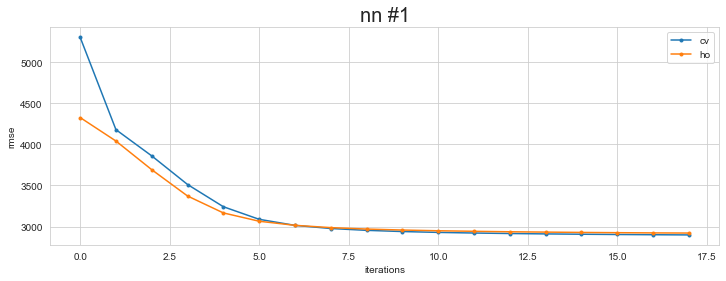

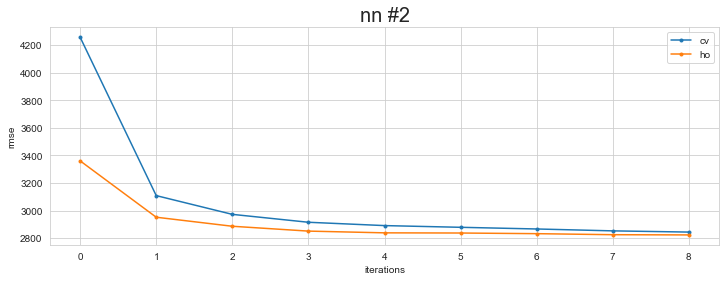

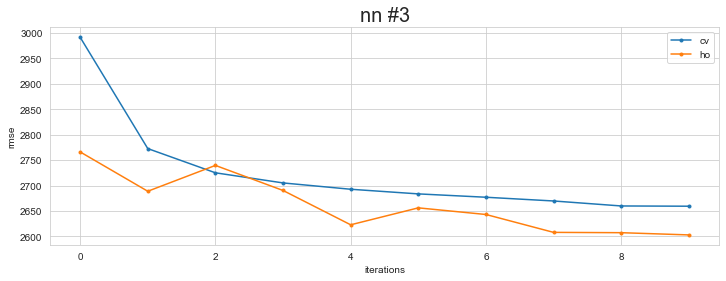

In [104]:
for i, cv_results in enumerate(L_fitted_nn):
    h = cv_results.history
    pd.DataFrame(np.c_[h['rmse'], h['val_rmse']]).plot(marker = '.', figsize = (12, 4))
    plt.xlabel('iterations')
    plt.ylabel('rmse')
    plt.legend(['cv', 'ho'])
    plt.title('nn #{}'.format(i+1), fontsize = 20)
    plt.show()

In [112]:
cvAB.loc['nn', 'cv'] = np.min([np.min(cv_results.history['rmse']) for cv_results in L_fitted_nn])
cvAB.loc['nn', 'ho'] = np.min([np.min(cv_results.history['val_rmse']) for cv_results in L_fitted_nn])

In [113]:
cvAB

,cv,ho
stacking,1638.958060,1635.472114
Lightgbm,1662.751215,1657.069782
Xgboost,1669.122544,1660.103616
RandomForest,1726.751485,1713.294672
ExtraTrees,1729.006396,1716.470925
DecisionTree,1985.362717,1955.076225
ExtraTree,2214.527492,2198.957705
Ridge,2173.712018,2204.543475
LinearSVR,2218.436281,2249.249173
nn,2659.278320,2602.836426
